<Center>

### Figures for the article:

## Simulating neutron diffraction in deformed mosaic crystals in McStas
<Center>

In [79]:
import numpy as np
import pandas as pd
from iminuit import Minuit, cost
import matplotlib.pyplot as plt
import matplotlib as mpl
import mcstasscript as ms
import copy
import os
import re
from pathlib import Path

def alpha_cmap(base_color="blue", N=256):
    """
    Create a colormap that keeps base_color fixed in RGB,
    and only varies the alpha channel from 0→1.

    Parameters
    ----------
    base_color : str or tuple
        Matplotlib color spec (e.g. "blue", "#1f77b4", (r,g,b)).
    N : int
        Number of discrete levels in the colormap.

    Returns
    -------
    cmap : matplotlib.colors.ListedColormap
    """
    rgb = np.array(mpl.colors.to_rgb(base_color))
    colors = np.tile(rgb, (N, 1))              # repeat base color
    alphas = np.linspace(0, 1, N)[:, None]     # column vector
    rgba = np.hstack([colors, alphas])         # combine RGB + alpha
    return mpl.colors.ListedColormap(rgba)
save_plots = True
plt.rcParams.update({
    "text.usetex": True,
    "font.size": 20,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.top": True,
    "ytick.right": True,
    "xtick.minor.visible": True,
    "ytick.minor.visible": True,
    "image.cmap": "terrain"
    })
colors = ['blue', "black", 'red']
linestyles = ['-', '--', '-.']






### X-profiles


Test trajectory for ksi_0=0 and ksi_=-0.5
R  = 5 m
x_source = 0 mm
x_slit   = -0.5 mm
path to reflection (2nd order): 0.276654 mm
path to reflection (1st order): 0.276662 mm
x_detector = 0.30188 mm


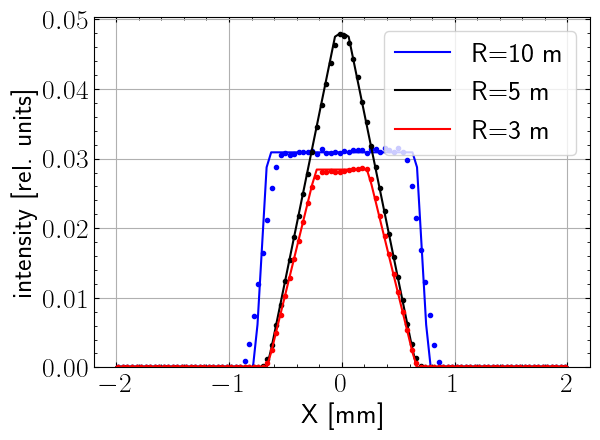

R [m]	beta/v [1/m]	reflectivity
10	0.0699145	0.915965
5	0.139829	0.710112
3	0.233048	0.524295


In [69]:
# -*- coding: utf-8 -*-
"""Analytical solution for path to reflection, bent perfect crystal.

Support material to the article:
"Simulating neutron diffraction from deformed mosaic crystals in McStas"

Calculation is done for the validation instrument setup described in the paper:

- collimation by two distant slits of equal width
- Ge511, cutting angle 19.45 deg
- monochromatic beam
- zero mosaicity (bent perfect crystal)

Solved in the diffraction plane (x,z), x is normal to the front surface 
of the crystal.

Output
------
    - Calculation of neutron trajectory for a selected set of random variables 
        (positions at the slits).
    - Calculation of beam profile at the detector for R=3, 5 and 10 m. 

Created on Thu Oct 16 16:45:00 2025
@author: saroun@ujf.cas.cz
"""

import numpy as np
import os
from matplotlib import pyplot as plt
from numpy import sin, cos
deg = np.pi/180
hovm = 6.296223627e-1*2*np.pi #  h/m_n [m/ms*A]  

def normsq(v): return v.dot(v)

#%% setup parameters

wavelength = 1.5 # A

# slit width
w = 1 # mm

# distance
L = 1e4 # mm

# Bragg angle
thB = 87.0674/2*deg

# cutting nagle
chi = -19.47*deg

# radius of curvature
R = 5*1e3 # mm
rho = 1/R

# Poisson constant
kappa = 0.2727

output_path = r'./data'

# neutron velocity m/ms
v = hovm/wavelength

#%% Ge511 parameters

dhkl = 1.08888 # A
b = 8.185 # fm
V0 = 22.63*8 # A^3
DW = 0.7833 # DW factor calculated in SIMRES
# structure factor
F = 4*np.sqrt(2)*b  # fm
# kinematic reflectivity
Qhkl = 0.01*wavelength**3*(F/V0)**2/sin(2*thB)


#%% Define vectors

"""NOTE:
  k-vectors are normalized to 1. 
  We assume that the crystal is aligned in Bragg position, so that the central 
  ray is diffracted at the centre of the crystal. It also implies that 
  |k + tau| = |k|
  |tau| = 2*sin(thB)
  
"""

# diffraction vector (nominal)
tau = 2*sin(thB)*np.array([cos(chi),sin(chi)])

# incident wave vector
k0 = np.array([-sin(thB+chi),cos(thB+chi)])

# diffracted wave vector, k+tau
kG = np.array([sin(thB-chi),cos(thB-chi)])

# unit vector normal to k
uT = np.array([cos(thB+chi),sin(thB+chi)])

# unit vector normal to kG (=detector x-axis)
uD = np.array([-cos(thB-chi),sin(thB-chi)])

# gradient of diffraction vector excluding curvature
grad = 2*sin(thB)*np.array([
    [-kappa*cos(chi),  sin(chi)],
    [ sin(chi)      , -cos(chi)]]
    )


#%% Check path to reflection
"""
Assume incident trajectory, r = r0 + k0*t.

We assume monochromatic beam, then the k-vector deviation from k0 is only due to 
divergence. In small-angle approximation we get dk = w/L*(ksi_1-ksi_0)*uT, 
where ksi_0, ksi_1 are two uniform random numbers on (-0.5;0.5). 
Then r0 = w/L*ksi_1*uT. Here we choose fixed ksi's for testing.
"""
ksi_0 = 0
ksi_1 = -0.5

r0 = w*ksi_1*uT
dk = w/L*(ksi_1-ksi_0)*uT

# Bragg condition
def bragg_condition(t, rho):
    return normsq(k0 + dk + tau + grad.dot(r0 + k0*t)*rho) - normsq(k0 + dk)

# solve for t
def solve_B(r0, dk, rho):
    """Solve Bragg condition for time to reflection.
    
    Full solution (quadratic).    
    """
    k = kG+dk
    gamma = k.dot(grad)*rho
    eps0 = 2*tau.dot(dk) + 2*gamma.dot(r0) + normsq(grad.dot(r0)*rho)
    if abs(eps0)<1e-16:
        t = 0
    else:        
        B = 2*(grad.dot(r0)).dot(grad.dot(k0))*rho**2
        B += 2*(kG+dk).dot(grad.dot(k0))*rho
        A = normsq(grad.dot(k0)*rho)        
        det2 = B**2 - 4*eps0*A
        if det2<-1e-10:
            t = np.inf
        elif det2<1e-10:
            t = -B/2/A
        else:
            t1 = (-B + np.sqrt(det2))/2/A
            t2 = (-B - np.sqrt(det2))/2/A
            if abs(t1)<abs(t2):
                t = t1
            else:
                t = t2
    return t


def solve_B_lin(r0, dk, rho):
    """Solution for t in the 1st order approximation."""
    eps0 = tau.dot(dk) + kG.dot(grad.dot(r0))*rho
    B = kG.dot(grad.dot(k0))*rho
    return -eps0/B




#%% Position at the detector

# Take the solution for t and calculate position of reflection
t = solve_B_lin(r0, dk, rho)
r = r0 + k0*t
# and project it to the detector axis
xd = r.dot(uD)

print('Test trajectory for ksi_0={:g} and ksi_={:g}'.format(ksi_0, ksi_1))
print('R  = {:g} m'.format(R/1000))
print('x_source = {:g} mm'.format(w*ksi_0))
print('x_slit   = {:g} mm'.format(w*ksi_1))
print('path to reflection (2nd order): {:g} mm'.format(solve_B(r0, dk, 1/R)))
print('path to reflection (1st order): {:g} mm'.format(solve_B_lin(r0, dk, 1/R)))
print('x_detector = {:g} mm'.format(xd))

#%% Beam profile at the detector, derivation

# Let's substitute for r0 and dk in solve_B_lin:
eps0 = w*((ksi_1-ksi_0)/L*tau.dot(uT) + ksi_1*rho*kG.dot(grad.dot(uT)))

# collect terms at ksi_1 and ksi_2 (excl. w)
eps0_0 = -tau.dot(uT)/L
eps0_1 = tau.dot(uT)/L + kG.dot(grad.dot(uT))*rho
eps0 = w*(eps0_1*ksi_1 + eps0_0*ksi_0)
B = kG.dot(grad.dot(k0))*rho # from solve_B_lin
t = -eps0/B

# and calculate position at the detector xd = r0 + k0*t
xd = (r0 - k0*eps0/B).dot(uD)
# then substitute for r0 and eps0 
xd = (w*ksi_1*uT - k0*w*(eps0_1*ksi_1 + eps0_0*ksi_0)/B).dot(uD)
# and collect terms at ksi's
xd_0 = - k0.dot(uD)*eps0_0/B
xd_1 = uT.dot(uD) - k0.dot(uD)*eps0_1/B
xd = w*(ksi_0*xd_0 + ksi_1*xd_1)
"""
So xd is a convolution of 2 uniform random numbers, which gives a trapezoid 
distribution, or triangular in the special case when |xd_0| = |xd_1|. 
"""

#%% Generate plot of the beam profile

def reflectivity(rho,Qhkl,DW):
    """Reflectivity of a bent crystal.
    
    Parameters
    ----------
    rho : float
        crystal curvature in 1/mm
    Qhkl : float
        kin. reflectivity in 1/cm
    DW : float
        D-W factor
    """
    # beta/v from the paper
    beta = -rho*kG.dot(grad.dot(k0))/sin(2*thB) # A/mm/A*m/ms = 1000/mm
    arg = 0.1*DW*Qhkl/abs(beta)  
    ref = 1 - np.exp(-arg)
    return ref

def x_det(x, rho, Qhkl=0.2209E-02, DW=0.7833):
    """Convolution of the 2 uniform distributions.
    
    Parameters
    ----------
    x : array_like
        detector positions in mm
    rho : float
        crystal curvature in 1/mm
    Qhkl : float
        kin. reflectivity in 1/cm
    DW : float
        D-W factor
    """
    one = np.ones(len(x))
    eps0_0 = -tau.dot(uT)/L
    eps0_1 = tau.dot(uT)/L + kG.dot(grad.dot(uT))*rho
    B = kG.dot(grad.dot(k0))*rho
    xd_0 = abs(-k0.dot(uD)*eps0_0/B)*one
    xd_1 = abs(uT.dot(uD) - k0.dot(uD)*eps0_1/B)*one
    # get overlap of the 2 uniform distributions
    xlim = [-0.5*xd_0, 0.5*xd_0, -0.5*xd_1+x,  0.5*xd_1+x]
    xmin = np.maximum(xlim[0], xlim[2])
    xmax = np.minimum(xlim[1], xlim[3])
    m1 = np.array(xmax>xmin, dtype=int)
    y = w*(xmax-xmin)*m1
    # normalize to unit integral
    itg = np.sum(y)*(x[1]-x[0])
    y /= itg
    y *= reflectivity(rho,Qhkl,DW)
    return y



#%% Compare with simulations
rkeys = [10, 5, 3] # R values to collect

# calculate theoretical beam profiles and save
x = np.linspace(-2, 2, num=100, dtype=float)
data = {'x':x}
hdr = ['x']
for R in rkeys:
    data[R] = x_det(x, 1/R*1e-3)
    hdr.append('R={:g}'.format(R))
hdr = '\t'.join(hdr)
np.savetxt(os.path.join(output_path,'beam_profile_calculated.dat'), 
           np.array(list(data.values())).T, fmt='%g', header = hdr)

# collect simulated beam profiles if available
data_sim = {}
for R in rkeys:
    fname = os.path.join("analytical_focusing",'beam_det_R{}m.dat'.format(R))
    try:
        data_sim[R] = np.loadtxt(fname, skiprows=13)
    except:
        data_sim[R] = None
        print('Cannot load simulated data: {}'.format(fname))

# plot
clrs = ['r','g','r']
# colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# colors = ['teal', 'black', 'crimson']
scale = max(data_sim[5][:,1])/max(data[5])
for i in range(len(rkeys)):
    R = rkeys[i]
    if R in data_sim and data_sim[R] is not None:
        x = data_sim[R][:,0]
        y = data_sim[R][:,1]
        plt.plot(x, y, marker='.', linestyle='none', color=colors[i])
    plt.plot(data['x'], data[R]*scale, label='R={:g} m'.format(R), color=colors[i])

plt.xlabel('X [mm]')
plt.ylabel('intensity [rel. units]')
plt.ylim(0)
plt.legend()
plt.tight_layout()
plt.grid()
plt.savefig(os.path.join('./','beam_profile_calculated.png'), dpi=300)
plt.show()    


# report beta and reflectivity values
hdr = {'R': 'R [m]',
       'beta':'beta/v [1/m]',
       'ref':'reflectivity'}
table = {'R':[], 'beta':[], 'ref':[]}
print('\t'.join(list(hdr.values())))
for R in rkeys:
    table['R'].append(R)
    # beta/v from the paper
    beta = -1e-3/R*kG.dot(grad.dot(k0))/sin(2*thB) # 1/mm 
    table['beta'].append(beta)
    # reflectivity from the paper
    arg = 0.1*DW*Qhkl/abs(beta) #  
    ref = 1 - np.exp(-arg)
    table['ref'].append(ref)
    print('{:g}\t{:g}\t{:g}'.format(R, beta*1e3, ref))







0.03010590271884865
0.030746581952143807
0.031243754996003195


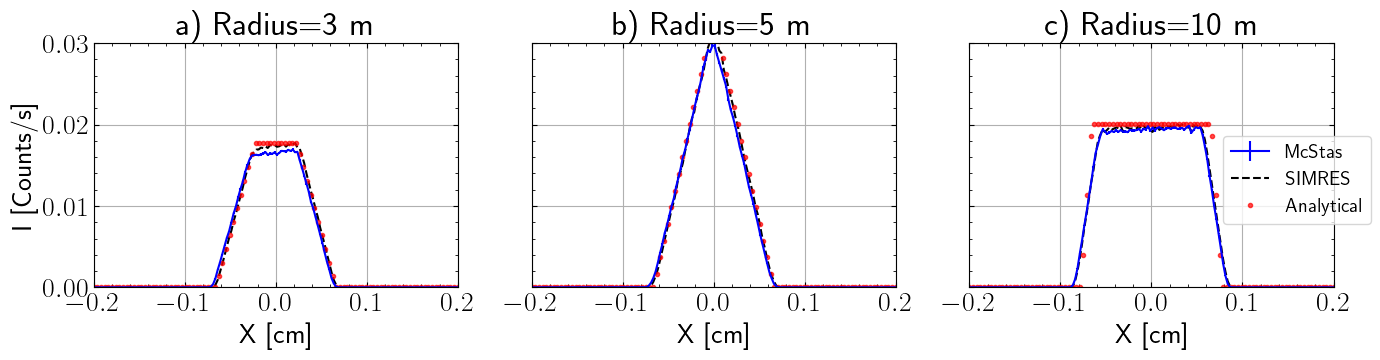

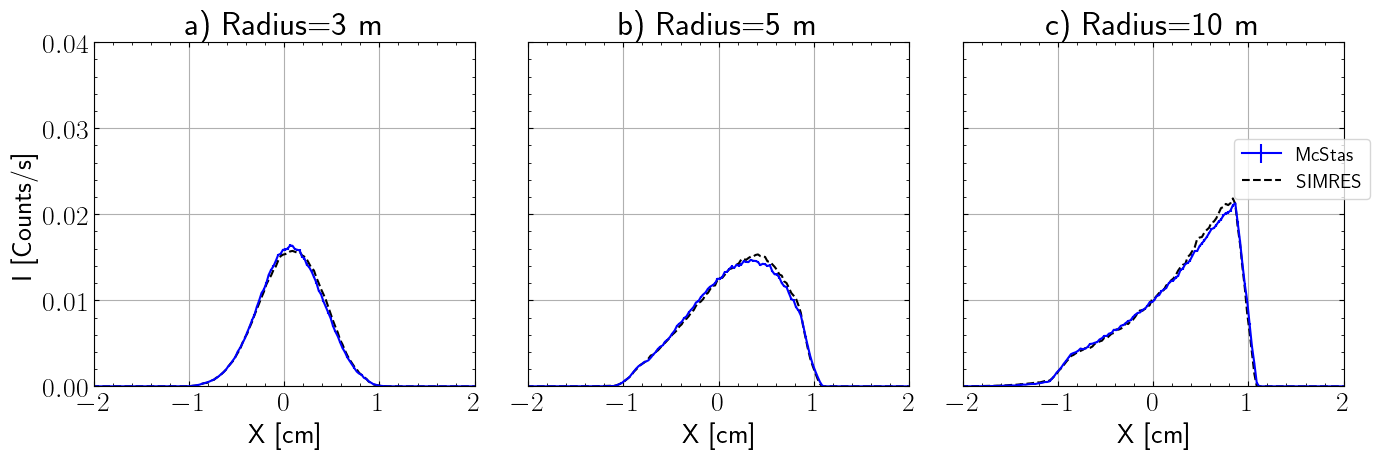

In [70]:

    
plot_number = ["a)", "b)", "c)", "d)"]
mosaicity = 0
radii = [3,5,10]
# X-profile of varying mosaicities
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(14, 4), sharey=True)
# filename = './data/X_profile_sandwich/det1d.dat'
# data = pd.read_table(filename, sep=r'\s+', comment='#', header=None)
# X,I,E,N = data[0],data[1],data[2],data[3]
# ax[2].errorbar(X, I, yerr=E, label='McStas', color=colors[2],linestyle=linestyles[2])

data = pd.read_csv('./simres/Rocking_curve_radius_3_mos_0.dat', sep=r'\s+', skiprows=3)
beam_profile_analytical = np.loadtxt('./data/beam_profile_calculated.dat')
for i, radius in enumerate(radii):
    filename = f'./data/X_profile_radius_{radius}_mos_{mosaicity}/det1d.dat'
    data = pd.read_table(filename, sep=r'\s+', comment='#', header=None)
    X,I,E,N = data[0],data[1],data[2],data[3]
    mcstas = ax[i].errorbar(X, I, yerr=E, label='McStas', color=colors[0],linestyle=linestyles[0])

    filename = f'./simres/X_profile_radius_{radius}_mos_{mosaicity}.dat'
    data = pd.read_table(filename, skiprows=13,sep=r'\s+', comment='#', header=None)
    X,I= data[0]/10,data[1]
    simres = ax[i].plot(X, I, label='SIMRES', color=colors[1],linestyle=linestyles[1])
    ax[i].set(xlabel='X [cm]', xlim=(-0.2, 0.2), ylim=(0, 0.03),
           title=f"{plot_number[i]} Radius={radius} m",xticks=[-0.2, -0.1, 0, 0.1, 0.2])
    if i == 0:
        ax[i].set_ylabel('I [Counts/s]')
    ax[i].grid(True)
    ax[i].minorticks_on()
    # load normalizing monitor
    norm = max(I)/max(beam_profile_analytical[:,3-i])
    print(norm)
    analytical = ax[i].plot(beam_profile_analytical[:,0]/10, beam_profile_analytical[:,3-i]*norm,
                            '.r', markersize=6, alpha=0.7,
                            label='Analytical')
    if i==2:
        fig.legend(handles=[mcstas,simres[0], analytical[0]],loc='center right',fontsize=14)

fig.tight_layout()
if save_plots: fig.savefig('X_profile_perfect.png', dpi=300)

mosaicity = 6
radii = [3,5,10]
# X-profile of varying bending radii
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(14, 5), sharey=True)
data = pd.read_table(f'./data/X_profile_NCrystal/det1d.dat', sep=r'\s+', comment='#', header=None)
X,I,E,N = data[0],data[1],data[2],data[3]
#ax[3].errorbar(X, I, yerr=E, label='McStas - NCrystal', color=colors[2], linestyle=linestyles[2])
for i, radius in enumerate(radii):
    data = pd.read_table(f'./data/X_profile_radius_{radius}_mos_{mosaicity}/det1d.dat', sep=r'\s+', comment='#', header=None)
    X,I,E,N = data[0],data[1],data[2],data[3]
    mcstas = ax[i].errorbar(X, I, yerr=E, label='McStas', color=colors[0], linestyle=linestyles[0])
    filename = f'./simres/X_profile_radius_{radius}_mos_{mosaicity}.dat'
    data = pd.read_table(filename, skiprows=13,sep=r'\s+', comment='#', header=None)
    X,I= data[0]/10,data[1]
    simres = ax[i].plot(X, I, label='SIMRES', color=colors[1],linestyle=linestyles[1])
    ax[i].set(xlabel='X [cm]', xlim=(-2, 2), ylim=(0, 0.04),
           title=f"{plot_number[i]} Radius={radius} m",xticks=[-2, -1, 0, 1, 2])
    if i == 0:
        ax[i].set_ylabel('I [Counts/s]')
    ax[i].grid(True)
    ax[i].minorticks_on()
    if i==2:
        fig.legend(handles=[mcstas,simres[0]],bbox_to_anchor=(1,0.7),fontsize=14)
fig.tight_layout()
if save_plots: fig.savefig('X_profile_mosaic.png', dpi=300)


### Rocking curves

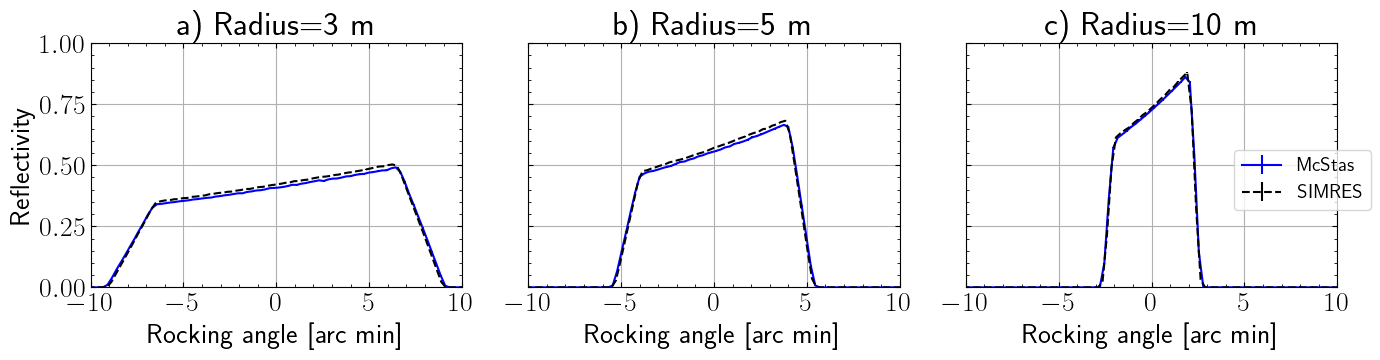

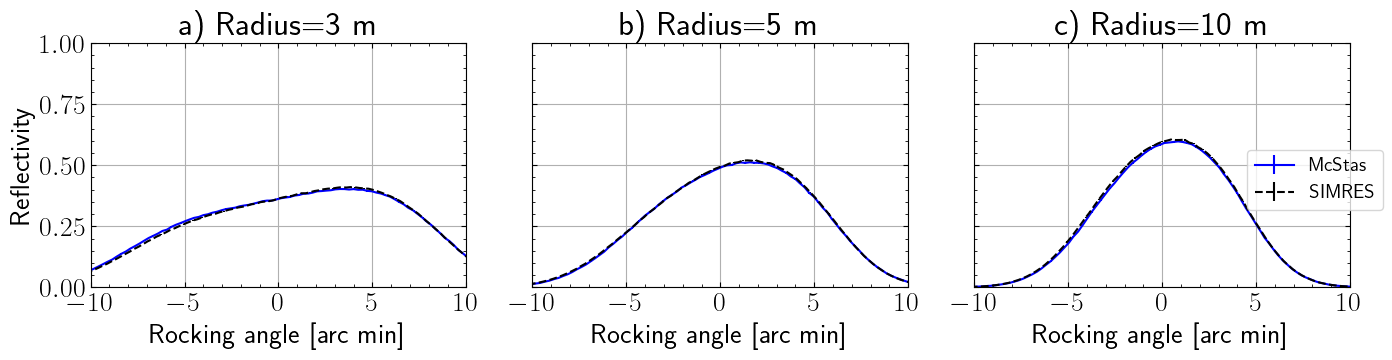

In [71]:
mosaicity = 0
radii = [3,5,10]
# Rocking curves of varying mosaicities
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(14, 4), sharey=True)
for i, radius in enumerate(radii):
    x = np.linspace(-0.2*60, 0.2*60, 100)
    intensity = []
    errors = []
    for j in range(100):
        normalization = pd.read_table(f'./data/Rocking_curve_radius_{radius}_mos_{mosaicity}/{j}/entry_monitor.dat', sep=r'\s+', comment='#', header=None)
        norm = np.sum(normalization[0:199].values)
        norm_err = np.sqrt(np.sum(normalization[200:399].values**2))
        data = pd.read_table(f'./data/Rocking_curve_radius_{radius}_mos_{mosaicity}/{j}/det1d.dat', sep=r'\s+', comment='#', header=None)
        X,I,E,N = data[0],data[1],data[2],data[3]
        I = sum(I)
        E = np.sqrt(sum(E**2))
        if I!=0:
            Ef = I/norm*((E/I)**2 + (norm_err/norm)**2)**0.5
        else:
            Ef = 0
        I = I/norm
        intensity.append(I)
        errors.append(E)
    ax[i].errorbar(x, intensity, yerr=errors, label='McStas', color=colors[0], linestyle=linestyles[0])
    filename = f'./simres/Rocking_curve_radius_{radius}_mos_{mosaicity}.dat'
    data = pd.read_table(filename, skiprows=4,sep=r'\s+', comment='#', header=None)
    X,I,E,N= data[0]*60,data[1]/norm,data[2],data[3]
    ax[i].errorbar(X, I,yerr=E, label='SIMRES', color=colors[1], linestyle=linestyles[1])

    ax[i].set(xlabel='Rocking angle [arc min]', title=f"{plot_number[i]} Radius={radius} m",
               xlim=(-10, 10), ylim=(0, 1), xticks=[-10, -5, 0, 5, 10])
    if i == 0:
        ax[i].set_ylabel('Reflectivity')
    ax[i].grid(True)
    ax[i].minorticks_on()
    if i==2:
        fig.legend(['McStas', 'SIMRES'],loc='center right',fontsize=14)
    fig.tight_layout()
if save_plots: fig.savefig('Rocking_curve_perfect.png', dpi=300)

mosaicity = 6
radii = [3,5,10 ]
# Rocking curve of varying bending radii
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(14, 4), sharey=True)
for i, radius in enumerate(radii):
    x = np.linspace(-0.2*60, 0.2*60, 100)
    intensity = []
    errors = []
    for j in range(100):
        normalization = pd.read_table(f'./data/Rocking_curve_radius_{radius}_mos_{mosaicity}/{j}/entry_monitor.dat', sep=r'\s+', comment='#', header=None)
        norm = np.sum(normalization[0:199].values)
        norm_err = np.sqrt(np.sum(normalization[200:399].values**2))
        data = pd.read_table(f'./data/Rocking_curve_radius_{radius}_mos_{mosaicity}/{j}/det1d.dat', sep=r'\s+', comment='#', header=None)
        X,I,E,N = data[0],data[1],data[2],data[3]
        I = sum(I)
        E = np.sqrt(sum(E**2))
        if I!=0:
            Ef = I/norm*((E/I)**2 + (norm_err/norm)**2)**0.5
        else:
            Ef = 0
        I = I/norm
        intensity.append(I)
        errors.append(E)
    ax[i].errorbar(x, intensity, yerr=errors, label='McStas', color=colors[0], linestyle=linestyles[0])
    
    
    filename = f'./simres/Rocking_curve_radius_{radius}_mos_{mosaicity}.dat'
    data = pd.read_table(filename, skiprows=4,sep=r'\s+', comment='#', header=None)
    X,I,E,N= data[0]*60,data[1]/norm,data[2],data[3]
    ax[i].errorbar(X, I,yerr=E, label='SIMRES', color=colors[1], linestyle=linestyles[1])
    ax[i].set(xlabel='Rocking angle [arc min]', title=f"{plot_number[i]} Radius={radius} m",
               xlim=(-10, 10), ylim=(0, 1), xticks=[-10, -5, 0, 5, 10])
    if i == 0:
        ax[i].set_ylabel('Reflectivity')
    ax[i].grid(True)
    ax[i].minorticks_on()
    if i==2:
        fig.legend(['McStas', 'SIMRES'],loc='center right',fontsize=14)
intensity = []
errors = []
for j in range(100):
    normalization = pd.read_table(f'./data/Rocking_curve_NCrystal/{j}/entry_monitor.dat', sep=r'\s+', comment='#', header=None)
    norm = np.sum(normalization[0:199].values)
    norm_err = np.sqrt(np.sum(normalization[200:399].values**2))
    data = pd.read_table(f'./data/Rocking_curve_NCrystal/{j}/det1d.dat', sep=r'\s+', comment='#', header=None)
    X,I,E,N = data[0],data[1],data[2],data[3]
    I = sum(I)
    E = np.sqrt(sum(E**2))
    if I!=0:
        Ef = I/norm*((E/I)**2 + (norm_err/norm)**2)**0.5
    else:
        Ef = 0
    I = I/norm
    intensity.append(I)
    errors.append(E)
#ax[3].errorbar(x, intensity, yerr=errors, label='McStas - NCrystal', color=colors[2], linestyle=linestyles[2])
#ax[3].legend(fontsize=12)
fig.tight_layout()
if save_plots: fig.savefig('Rocking_curve_mosaic.png', dpi=300)

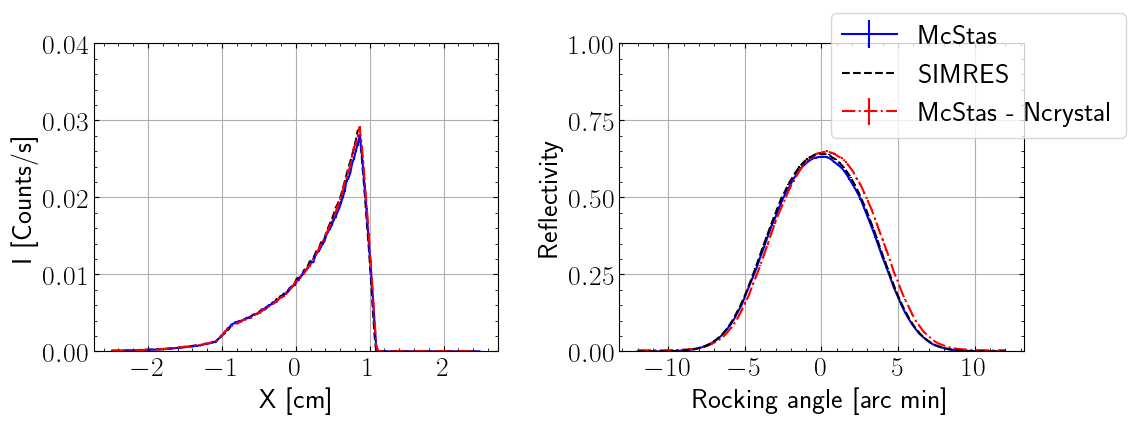

In [72]:
# Flat crystal plots
# import the mcstas and ncrystal data
x_profile_mcstas = ms.load_data(f'./data/X_profile_radius_1000_mos_6')[-6]
x_profile_ncrystal = ms.load_data('./data/X_profile_NCrystal')[-6]

rocking_angle_intensity_mcstas = []
mcstas_x = []
mcstas_err = []

rocking_ncrystal = []
ncrystal_err = []
ncrystal_x = []
for i in range(100):
    res = ms.load_metadata(f'./data/Rocking_curve_radius_1000_mos_6/{i}')
    norm_mon = res[0].total_I
    norm_err = res[0].total_E
    mon = res[-6].total_I
    mon_err = res[-6].total_E
    rock_err = mon/norm_mon*((np.divide(mon_err,mon,  out=np.zeros_like(mon), where=mon!=0))**2 + (norm_err/norm_mon)**2)**0.5
    rocking_angle_intensity_mcstas.append(mon/norm_mon)
    mcstas_x.append(res[-6].parameters['DeltaBragg'])
    mcstas_err.append(rock_err)

    res_ncryst = ms.load_metadata(f'./data/Rocking_curve_NCrystal/{i}')
    norm_mon = res_ncryst[0].total_I
    norm_err = res_ncryst[0].total_E
    mon = res_ncryst[-6].total_I
    mon_err = res_ncryst[-6].total_E
    rock_err = mon/norm_mon*((np.divide(mon_err,mon,  out=np.zeros_like(mon), where=mon!=0))**2 + (norm_err/norm_mon)**2)**0.5
    rocking_ncrystal.append(mon/norm_mon)
    ncrystal_x.append(res[-6].parameters['DeltaBragg'])
    ncrystal_err.append(rock_err)    





    


# Import the simres data


filename = f'./simres/X_profile_radius_1000_mos_6.dat'
data = pd.read_table(filename, skiprows=13,sep=r'\s+', comment='#', header=None)
x_profile_simres_x,x_profile_simres_i= data[0]/10,data[1]

filename = f'./simres/Rocking_curve_radius_1000_mos_6.dat'
data = pd.read_table(filename, skiprows=4,sep=r'\s+', comment='#', header=None)
simres_x, simres_I, simres_E = data[0], data[1]/norm_mon, data[2]


# Import the ncrystal data
fig, ax = plt.subplots(ncols=2, figsize=(12,4), gridspec_kw=dict(wspace=0.3))
mcstas = ax[0].errorbar(x_profile_mcstas.xaxis, x_profile_mcstas.Intensity, x_profile_mcstas.Error, label='McStas',color=colors[0], linestyle=linestyles[0])
simres = ax[0].plot(x_profile_simres_x, x_profile_simres_i, label='SIMRES', color=colors[1], linestyle=linestyles[1])
ncrystal = ax[0].errorbar(x_profile_ncrystal.xaxis, x_profile_ncrystal.Intensity, x_profile_ncrystal.Error, label='McStas - Ncrystal', color=colors[2], linestyle=linestyles[2])

ax[0].set(xlabel='X [cm]',
          ylabel=fr'I [Counts/s]',
          xticks=[-2, -1, 0, 1, 2],
          ylim=(0,0.04), yticks=[0,0.01,0.02,0.03,0.04])
ax[0].grid(True)

ax[1].errorbar(np.array(mcstas_x)*60, rocking_angle_intensity_mcstas, yerr=mcstas_err, color=colors[0], linestyle=linestyles[0])
ax[1].errorbar(np.array(ncrystal_x)*60, rocking_ncrystal, yerr=ncrystal_err, color=colors[2], linestyle=linestyles[2])
ax[1].errorbar(np.array(simres_x)*60, simres_I, yerr=simres_E, color=colors[1], linestyle=linestyles[1])

ax[1].set(ylim=(0,1),
          xlabel='Rocking angle [arc min]',
          ylabel='Reflectivity',
          xticks=[-10, -5, 0, 5, 10],
          yticks=[0,0.25,0.5,0.75,1])
ax[1].grid(True)
fig.legend(handles=[mcstas,simres[0],ncrystal])
if save_plots==True:
    fig.savefig('flat_crystal_x_and_rock.png',dpi=300, bbox_inches='tight')

/var/folders/m8/f330x_5d5lvdrkc5f7qn2b1h0000gn/T/ipykernel_72869/3045091642.py:108: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  denom = np.trapz(y, x)
/var/folders/m8/f330x_5d5lvdrkc5f7qn2b1h0000gn/T/ipykernel_72869/3045091642.py:109: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  num = np.trapz(x * y, x)


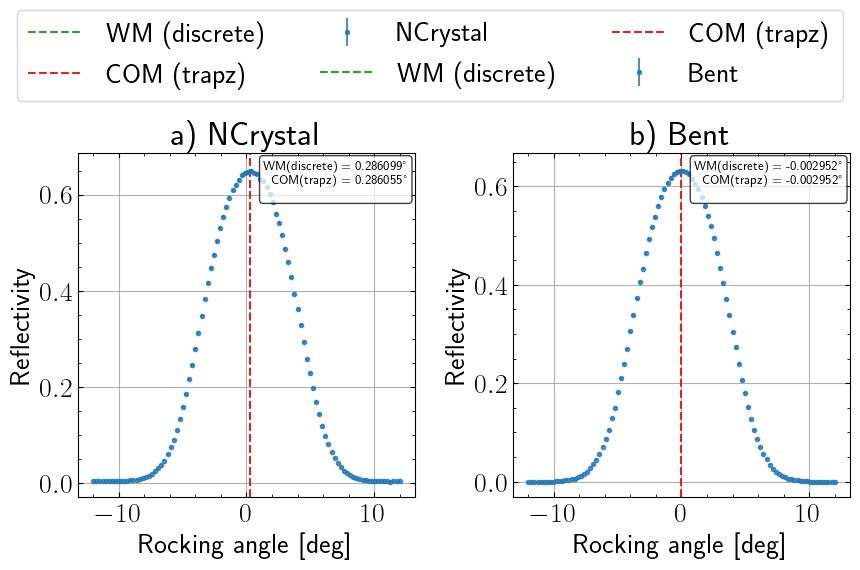

In [108]:
# Fit gaussian from mcstas for ncrystal and monochromator_bent.
# start with mono bent
# Perform plotting of primary extinction dependence
def parse_mccode_multiarray_1d(path):
    """
    Parse a McCode 'multiarray_1d' ASCII file into (meta, df).

    Parameters
    ----------
    path : str | Path
        File path to the .dat/.txt export.

    Returns
    -------
    meta : dict
        Header metadata: title, xlabel, ylabel, xvars, yvars (list of (I, ERR) pairs), variables (list), etc.
    df : pd.DataFrame
        Tidy numeric data with columns named like in 'variables'.
    """
    path = Path(path)
    header = []
    data_lines = []

    # Read and separate header (starting with '#') from numeric data
    with path.open("r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            s = line.strip()
            if not s:
                continue
            if s.startswith("#") or s.startswith("\\#"):
                header.append(s.lstrip("\\").lstrip("#").strip())
            else:
                data_lines.append(s)

    # Parse header key:value pairs
    meta = {}
    for h in header:
        # e.g., "title: Scan of DeltaBragg"
        if ":" in h:
            key, val = h.split(":", 1)
            meta[key.strip().lower()] = val.strip().strip("'\"")

    # Variables list (column order)
    variables = meta.get("variables", "")
    if variables:
        # split by whitespace respecting names like 'entry_monitor_I'
        var_cols = variables.split()
    else:
        raise ValueError("No 'variables' line found in header; cannot map columns.")

    meta["variables"] = var_cols

    # yvars groups: e.g., "(entry_monitor_I,entry_monitor_ERR) (lam_mon_I,lam_mon_ERR) ..."
    yvars_raw = meta.get("yvars", "")
    y_pairs = []
    if yvars_raw:
        # Extract tuples between parentheses
        for tup in re.findall(r"\((.*?)\)", yvars_raw):
            parts = [p.strip() for p in tup.split(",")]
            if len(parts) == 2:
                y_pairs.append(tuple(parts))
    meta["yvars_pairs"] = y_pairs

    # Build DataFrame from numeric lines
    # Numeric values may be in scientific notation like 3.46703e-05
    # Split by whitespace and convert to float
    matrix = []
    for dl in data_lines:
        # Robust split: any whitespace
        nums = dl.split()
        if len(nums) != len(var_cols):
            # Some rows may be truncated; skip safely
            continue
        try:
            matrix.append([float(n) for n in nums])
        except ValueError:
            # If any token fails, skip row
            continue

    df = pd.DataFrame(matrix, columns=var_cols)

    # Convenience aliases
    meta["title"] = meta.get("title", "")
    meta["xlabel"] = meta.get("xlabel", meta.get("xvars", var_cols[0]))
    meta["ylabel"] = meta.get("ylabel", "Intensity")

    return meta, df

# ---------- Helper functions for "center" calculations ----------
def clean_sort(x, y):
    """Remove NaNs and sort by x."""
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    mask = np.isfinite(x) & np.isfinite(y)
    x, y = x[mask], y[mask]
    idx = np.argsort(x)
    return x[idx], y[idx]

def weighted_mean_discrete(x, y):
    """Discrete weighted mean (center of mass for point weights)."""
    return np.average(a=x, weights=y)
   

def weighted_mean_trapz(x, y):
    """Continuous center of mass using trapezoidal integration (for sampled curves)."""
    x, y = clean_sort(x, y)
    y = np.clip(y, a_min=0, a_max=None)
    denom = np.trapz(y, x)
    num = np.trapz(x * y, x)
    return np.nan if denom == 0 else num / denom

# ---------- Your plotting code + center overlays ----------
fig, ax = plt.subplots(figsize=(9, 5), ncols=2)

# Load first dataset (NCrystal)
meta, df = parse_mccode_multiarray_1d(f"data/Rocking_curve_NCrystal/mccode.dat")
x0 = (df['DeltaBragg'] * 60).to_numpy()  # degrees
y0 = (df['x_monitor_I'] / df['entry_lam_mon_I']).to_numpy()
err0 = df['x_monitor_ERR'].to_numpy()

ax[0].errorbar(x0, y0, yerr=err0, label=r'NCrystal', fmt='o', ms=3, alpha=0.8)

# Load second dataset (Bent)
meta1, df1 = parse_mccode_multiarray_1d(f"data/Rocking_curve_radius_1000_mos_6/mccode.dat")
x1 = (df1['DeltaBragg'] * 60).to_numpy()  # degrees
y1 = (df1['x_monitor_I'] / df1['entry_lam_mon_I']).to_numpy()
err1 = df1['x_monitor_ERR'].to_numpy()

ax[1].errorbar(x1, y1, yerr=err1, label=r'Bent', fmt='o', ms=3, alpha=0.8)

# ---------- Compute centers for both datasets ----------
# NCrystal
mu_disc_0   = weighted_mean_discrete(x0, y0)
mu_trapz_0  = weighted_mean_trapz(x0, y0)
# Bent
mu_disc_1   = weighted_mean_discrete(x1, y1)
mu_trapz_1  = weighted_mean_trapz(x1, y1)

# ---------- Plot center markers & lines ----------
# Styling for centers
styles = {
    'WM (discrete)': dict(color='C2', ls='--'),
    'COM (trapz)':   dict(color='C3', ls='--'),
}

# NCrystal centers
ax[0].axvline(mu_disc_0,  label='WM (discrete)', **styles['WM (discrete)'])
ax[0].axvline(mu_trapz_0, label='COM (trapz)',   **styles['COM (trapz)'])


# Bent centers
ax[1].axvline(mu_disc_1,  label='WM (discrete)', **styles['WM (discrete)'])
ax[1].axvline(mu_trapz_1, label='COM (trapz)',   **styles['COM (trapz)'])

ax[0].set(xlabel='Rocking angle [deg]', ylabel='Reflectivity')
ax[1].set(xlabel='Rocking angle [deg]', ylabel='Reflectivity')
ax[0].grid(True)
ax[1].grid(True)

# ---------- Annotate numeric results in each subplot ----------
txt0 = (
    f"WM(discrete) = {mu_disc_0:.6f}°\n"
    f"COM(trapz)   = {mu_trapz_0:.6f}°\n"

)
ax[0].text(0.98, 0.98, txt0, transform=ax[0].transAxes,
           ha='right', va='top', fontsize=9,
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.75))

txt1 = (
    f"WM(discrete) = {mu_disc_1:.6f}°\n"
    f"COM(trapz)   = {mu_trapz_1:.6f}°\n"

)
ax[1].text(0.98, 0.98, txt1, transform=ax[1].transAxes,
           ha='right', va='top', fontsize=9,
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.75))
ax[1].set_title('b) Bent')
ax[0].set_title('a) NCrystal')
# Global legend from both axes
fig.legend(loc='lower center', bbox_to_anchor=(0.5, 0.95), ncol=3)
fig.tight_layout()
# fig.savefig("./difference.png", bbox_inches='tight', dpi=300)


0.612122878525677
0.8322289168476187
1.087160700340438


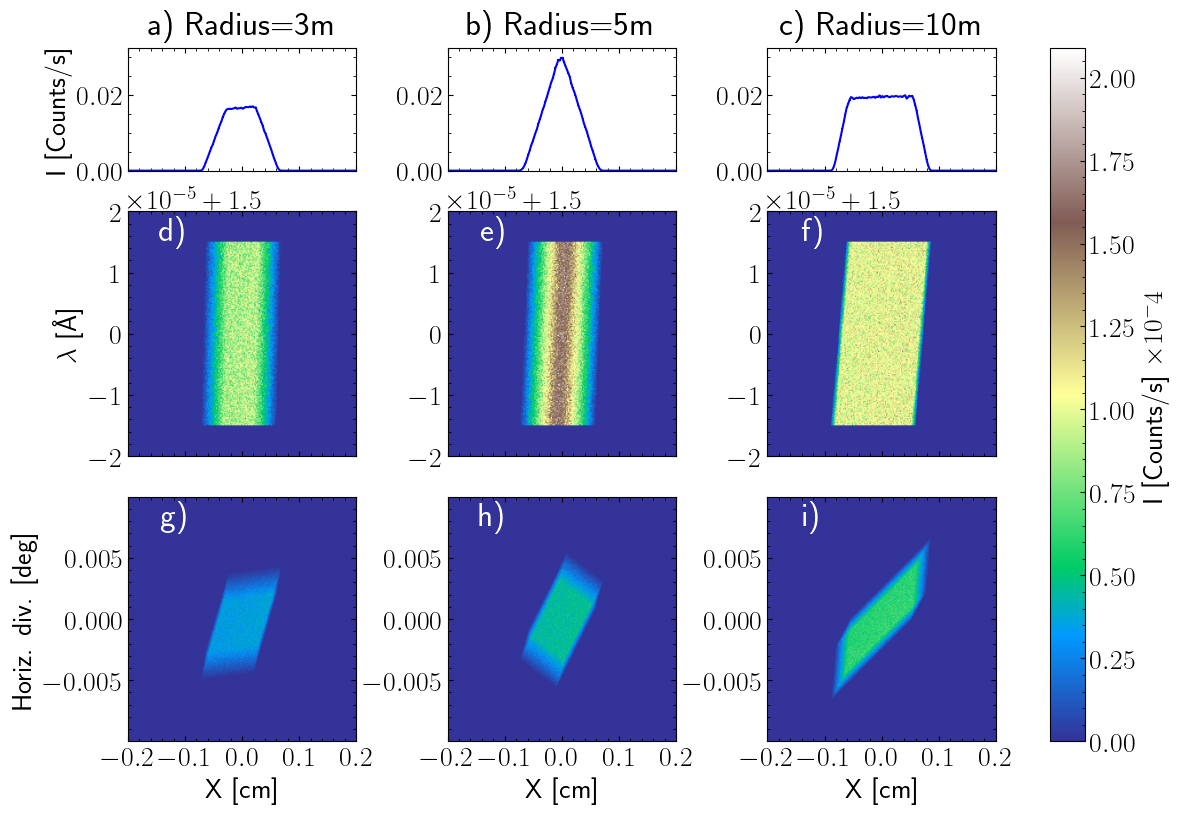

In [73]:
data = [ms.load_data(f'./data/X_profile_radius_{x}_mos_0') for x in [3,5,10]]
wave_mons = [x[-4] for x in data]
div_mons = [x[-2] for x in data]
intense_mons = [x[-6] for x in data]
max_intensity = 0
for wave_mon in wave_mons:
    wave_mon.Intensity *= 10000
    max_intensity = max_intensity if max_intensity> wave_mon.Intensity.max() else wave_mon.Intensity.max()
#    wave_mon.metadata.limits[2] -= 1.5
#    wave_mon.metadata.limits[3] -= 1.5
#    wave_mon.metadata.limits[2]*=100000
#    wave_mon.metadata.limits[3]*=100000
    wave_mon.metadata.limits[0]*=100
    wave_mon.metadata.limits[1]*=100
for div_mon in div_mons:
    div_mon.Intensity *=10000
    div_mon.metadata.limits[0] *=100
    max_intensity = max_intensity if max_intensity> div_mon.Intensity.max() else div_mon.Intensity.max()
    div_mon.metadata.limits[1] *=100


fig, ax = plt.subplots(ncols=3, nrows=3, 
                       gridspec_kw=dict(height_ratios=[1.5,3,3],
                                        width_ratios=[3,3,3],
                                        hspace=0.2, wspace=0.4),
                       figsize=(14,9), 
                       sharex=True, 
                       )


ax[1,0].imshow(wave_mons[0].Intensity, extent=wave_mons[0].metadata.limits,vmin=0, vmax=max_intensity, aspect='auto')
ax[1,1].imshow(wave_mons[1].Intensity, extent=wave_mons[1].metadata.limits, vmin=0, vmax=max_intensity,aspect='auto')
heat = ax[1,2].imshow(wave_mons[2].Intensity, extent=wave_mons[2].metadata.limits, vmin=0, vmax=max_intensity,aspect='auto')

# cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])

ax[0,0].errorbar(intense_mons[0].xaxis, intense_mons[0].Intensity, yerr=intense_mons[0].Error, color=colors[0],linestyle=linestyles[0])
ax[0,1].errorbar(intense_mons[1].xaxis, intense_mons[1].Intensity, yerr=intense_mons[1].Error, color=colors[0],linestyle=linestyles[0])
ax[0,2].errorbar(intense_mons[2].xaxis, intense_mons[2].Intensity, yerr=intense_mons[2].Error, color=colors[0],linestyle=linestyles[0])


ax[2,0].imshow(div_mons[0].Intensity, extent=div_mons[0].metadata.limits,vmin=0, vmax=max_intensity, aspect='auto')
ax[2,1].imshow(div_mons[1].Intensity, extent=div_mons[1].metadata.limits,vmin=0, vmax=max_intensity, aspect='auto')
ax[2,2].imshow(div_mons[2].Intensity, extent=div_mons[2].metadata.limits,vmin=0, vmax=max_intensity, aspect='auto')

for axes in ax[0]:
    axes.set(ylim=(0,0.0322))
for axes in ax[1]:
    axes.set()
for axes in ax[2]:
    
    axes.set(xlabel='X [cm]', xticks=[-0.2,-0.1,0,0.1,0.2],
             yticks=[-0.005,0,0.005])



ax[0,0].set_title('a) Radius=3m', y=1.05)
ax[1,0].set_ylabel(r'$\lambda$ [\AA]')
ax[2,0].set_ylabel(fr'Horiz. div. [deg]')
cbar = fig.colorbar(heat,ax=ax,label=fr'I [Counts/s] $\times 10^{-4}$')
ax[0,0].set(ylabel=fr'I [Counts/s]')
ax[0,2].set_title('c) Radius=10m', y=1.05)
ax[0,1].set_title('b) Radius=5m', y=1.05)

# Set titles of the non leading plots
ax[1,0].set_title('d)', y=0.85,x=0.2, color='w')
ax[1,1].set_title('e)', y=0.85,x=0.2, color='w')
ax[1,2].set_title('f)', y=0.85,x=0.2, color='w')
ax[2,0].set_title('g)', y=0.85,x=0.2, color='w')
ax[2,1].set_title('h)', y=0.85,x=0.2, color='w')
ax[2,2].set_title('i)', y=0.85,x=0.2, color='w')
for mon in intense_mons:
    print(sum(mon.Intensity))
if save_plots==True:
    fig.savefig('./Wavelength_position_narrow.png', dpi=300, bbox_inches='tight')

size of velocity vector in cm = 263733.3333333334
-263386.20574505103
tan theta = 0.9499601786461171
xd for R=3m =272.5559989787491 cm/ AA


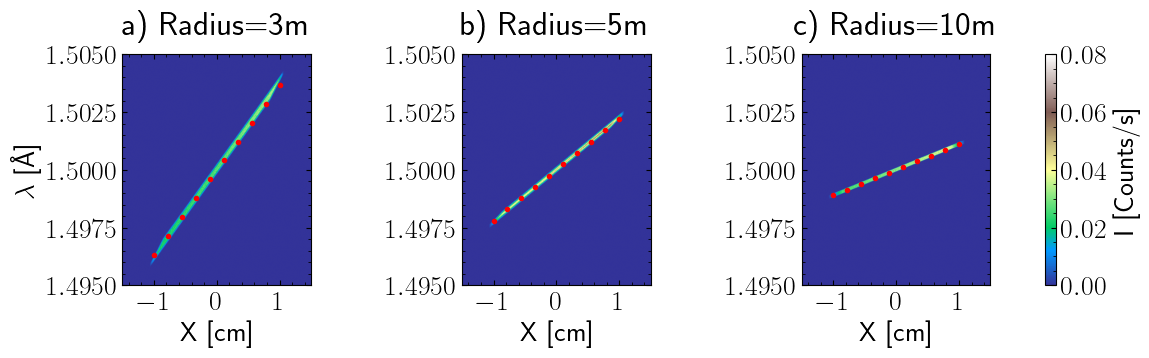

In [74]:
data = [ms.load_data(f'./data/X_profile_radius_{x}_mos_0_wavelength') for x in [3,5,10]]
wave_mons = [x[-3] for x in data]
div_mons = [x[-1] for x in data]
intense_mons = [copy.deepcopy(x) for x in wave_mons]


max_intensity = 0
for wave_mon in wave_mons:
#   wave_mon.Intensity *= 10000
    max_intensity = max_intensity if max_intensity> wave_mon.Intensity.max() else wave_mon.Intensity.max()
#    wave_mon.metadata.limits[2] -= 1.5
#    wave_mon.metadata.limits[3] -= 1.5
#    wave_mon.metadata.limits[2]*=100000
#    wave_mon.metadata.limits[3]*=100000
    wave_mon.metadata.limits[0]*=100
    wave_mon.metadata.limits[1]*=100
for div_mon in div_mons:
#   div_mon.Intensity *=10000
    div_mon.metadata.limits[0] *=100
    max_intensity = max_intensity if max_intensity> div_mon.Intensity.max() else div_mon.Intensity.max()
    div_mon.metadata.limits[1] *=100
for mon in intense_mons:
    I = mon.Intensity.sum(axis=0)
    X = (mon.metadata.limits[0]*100, mon.metadata.limits[1]*100)
    E = np.sqrt((mon.Error**2).sum(axis=0))
    mon.xaxis = np.linspace(X[0],X[1],500)
    mon.Intensity = I
    mon.Error = E






fig, ax = plt.subplots(ncols=3, nrows=1, 
                       gridspec_kw=dict(
                                        
                                        hspace=0.2, wspace=0.8),
                       figsize=(14,3), 
                       sharex=True
                       )
ax[0].imshow(wave_mons[0].Intensity, extent=wave_mons[0].metadata.limits,vmin=0, vmax=0.08, aspect='auto')
ax[1].imshow(wave_mons[1].Intensity, extent=wave_mons[1].metadata.limits, vmin=0, vmax=0.08,aspect='auto')
heat = ax[2].imshow(wave_mons[2].Intensity, extent=wave_mons[2].metadata.limits, vmin=0, vmax=0.08,aspect='auto')

#ax[0,0].errorbar(intense_mons[0].xaxis, intense_mons[0].Intensity, yerr=intense_mons[0].Error, color=colors[0],linestyle=linestyles[0])
#ax[0,1].errorbar(intense_mons[1].xaxis, intense_mons[1].Intensity, yerr=intense_mons[1].Error, color=colors[0],linestyle=linestyles[0])
#ax[0,2].errorbar(intense_mons[2].xaxis, intense_mons[2].Intensity, yerr=intense_mons[2].Error, color=colors[0],linestyle=linestyles[0])
#
#
#ax[2,0].imshow(div_mons[0].Intensity, extent=div_mons[0].metadata.limits,vmin=0, vmax=0.1, aspect='auto')
#ax[2,1].imshow(div_mons[1].Intensity, extent=div_mons[1].metadata.limits,vmin=0, vmax=0.1, aspect='auto')
#ax[2,2].imshow(div_mons[2].Intensity, extent=div_mons[2].metadata.limits,vmin=0, vmax=0.1, aspect='auto')
#
#for axes in ax[0]:
#    axes.set(ylim=(0,0.6))
#for axes in ax[1]:
#    axes.set()
for axes in ax:
    axes.set(xlabel='X [cm]')
#
#
ax[0].set_title('a) Radius=3m', y=1.05)
ax[0].set_ylabel(r'$\lambda$ [\AA]')
#ax[2,0].set_ylabel(fr'Horiz. div. [deg]')
cbar = fig.colorbar(heat,ax=ax,label=fr'I [Counts/s] ')
#ax[0,0].set(ylabel=fr'I [Counts/s]')
ax[2].set_title('c) Radius=10m', y=1.05)
ax[1].set_title('b) Radius=5m', y=1.05)
#
## Set titles of the non leading plots
#ax[1,0].set_title('d)', y=0.85,x=0.2, color='w')
#ax[1,1].set_title('e)', y=0.85,x=0.2, color='w')
#ax[1,2].set_title('f)', y=0.85,x=0.2, color='w')
#ax[2,0].set_title('g)', y=0.85,x=0.2, color='w')
#ax[2,1].set_title('h)', y=0.85,x=0.2, color='w')
#ax[2,2].set_title('i)', y=0.85,x=0.2, color='w')
#for mon in intense_mons:
#    print(sum(mon.Intensity))



modifier = 1.#03
def get_dlam(x,lam,theta,beta,vi, sd):
    return -x*lam*beta/np.tan(theta)/np.dot(sd,vi)*modifier + lam

def get_xd(dlam, lam, sd, vi, theta, beta):
    return -np.dot(sd,vi)*dlam/lam*np.tan(theta)/beta
# # incident wave vector
# k0 = np.array([-sin(thB+chi),cos(thB+chi)])

# # diffracted wave vector, k+tau
# kG = np.array([sin(thB-chi),cos(thB-chi)])

# # unit vector normal to k
# uT = np.array([cos(thB+chi),sin(thB+chi)])

# # unit vector normal to kG (=detector x-axis)
# uD = np.array([-cos(thB-chi),sin(thB-chi)])
# incoming speed vector
size_v = 3956/1.5*1e+2
print(f"size of velocity vector in cm = {size_v}")
chi = 19.47*np.pi/180
theta = 43.53*np.pi/180
thet = theta-chi
thet_out =theta + chi 
v = np.array([-np.sin(thet),0,np.cos(thet)])*size_v
Sd = np.array([np.cos(thet_out), 0,-np.sin(thet_out)]) 
print(np.dot(Sd,v))
print(f"tan theta = {np.tan(theta)}")


beta_10 = 184
beta_5 = 367
beta_3 = 612
lam = 1.5
x = np.linspace(-1, 1,10)

print(f"xd for R=3m ={get_xd(1,lam,Sd,v,theta,beta_3)*1/modifier} cm/ AA")
ax[2].plot(x, get_dlam(x,lam,theta,beta_10, v,Sd),'.r', label='Theoretical curve')
ax[1].plot(x, get_dlam(x,lam,theta,beta_5, v,Sd),'.r')
ax[0].plot(x, get_dlam(x,lam,theta,beta_3, v,Sd),'.r')

if save_plots==True:
    fig.savefig('./Wavelength_position_broad.png', dpi=300, bbox_inches='tight')


Mcstas simulation at 0.0063 m thickness  yields: 0.5851
Darwin Transfer equation at  yields: 0.5732
Effective cross section is 94.68
43.48128355165794
Darwin Transfer equation at 0.0063 m yields: 0.8131
Effective cross section is 502.2
Q_ge=0.17326312213351452, Q_Cu=1.1408110985861226, Y_Ge=0.953694, Y_Cu=0.768242


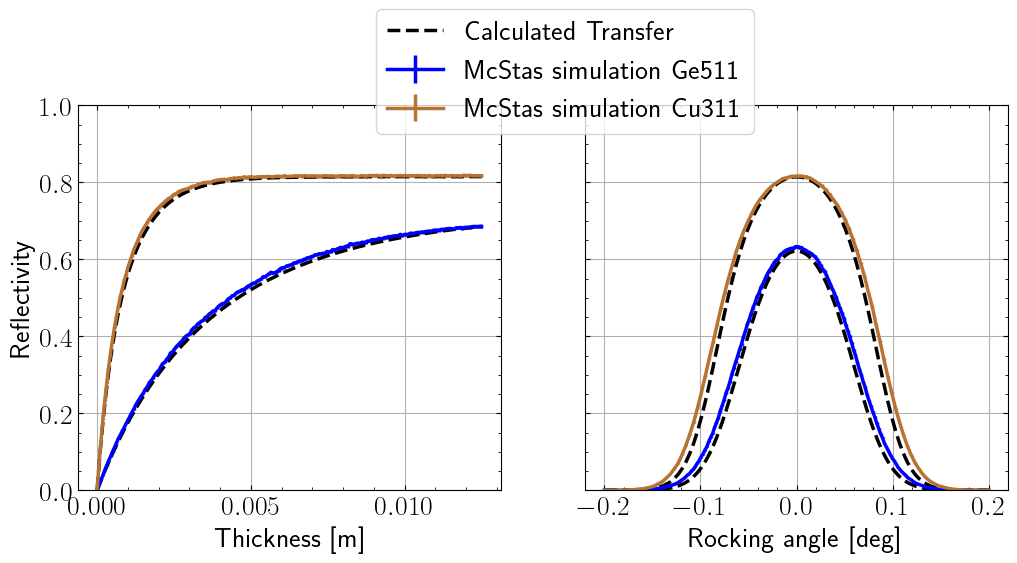

In [75]:
def reflectivity(sig, mu, D, rot):
    alpha = 1/np.cos((rot+19.47)*np.pi/180)
    beta = 1/np.cos((rot-19.47)*np.pi/180)
    gamma = np.sqrt((alpha+beta)**2*(sig+mu)**2 - 4*alpha*beta*sig**2)
    numerator = 2*alpha*sig
    denominator = (alpha + beta)*(sig + mu) + gamma/np.tanh(D*gamma/2)
    return np.array(numerator/denominator)

def effective_sigma(sig,Q, x):
    gauss = Q/sig * np.exp(-np.pi*x**2/(sig**2))
    return gauss

dat = ms.load_data('./data/X_profile_thickness/100')
thick = dat[0].metadata.parameters['cryst_thickness']
norm = dat[0].metadata.total_I
wave_mon = dat[2]
print(f"Mcstas simulation at {thick:.2g} m thickness  yields: {wave_mon.metadata.total_I/norm:.4g}")



Y_Ge = 0.953694 # Primary extinction for Ge
Q_Ge = 0.16524/Y_Ge # Q with everything, but remove the Y_Ge just to be pedantic
sig_Ge = Q_Ge*Y_Ge/(0.1*np.pi/180) # 0.1 is the mosaicity in deg, and is then changed to radians
mu_Ge = 15.443 # The attenuation coefficient used in the simulation

rotation_Ge = 43.53
print(f"Darwin Transfer equation at  yields: {reflectivity(sig_Ge,mu_Ge,thick, rotation_Ge):.4g}")
print(f"Effective cross section is {sig_Ge:.4g}")

# # Load in the mccode.sim file
file = "./data/X_profile_thickness/mccode.dat" 
thick_scan_Ge = np.loadtxt(file)
file = "./data/Rocking_curve_transfer/mccode.dat"
rot_scan_ge = np.loadtxt(file)


Y_Cu = 0.768242 # Primary extinction for Cu
Q_Cu = 0.876419/Y_Cu # Q extracted from mono_bent, but the Y_cu is taken away
sig_Cu = Q_Cu*Y_Cu/(0.1*np.pi/180) # 0.1 is the mosaicity in deg, and is then changed to radians
mu_Cu = 45.2435 # The attenuation coefficient extracted from mono bent.

rotation_Cu = 180/np.pi*np.asin(1.5/1.08993/2)
print(rotation_Cu)
print(f"Darwin Transfer equation at {thick:.2g} m yields: {reflectivity(sig_Cu,mu_Cu,thick, rotation_Cu):.4g}")
print(f"Effective cross section is {sig_Cu:.4g}")

# # Load in the mccode.sim file
file = "./data/X_profile_thickness_Cu/mccode.dat" 
thick_scan_Cu = np.loadtxt(file)
file = "./data/Rocking_curve_flat_mos_6_Cu/mccode.dat"
rot_scan_Cu = np.loadtxt(file)



second_colors = ['r-', 'b-']
linethickness = 2.5

fig, ax = plt.subplots(ncols=2, figsize=[12,5], sharey=True,gridspec_kw=dict() )
ax[0].errorbar(thick_scan_Ge[:,0], thick_scan_Ge[:,5]/thick_scan_Ge[:,1], thick_scan_Ge[:,6], 
                 label='McStas simulation Ge511', 
                 linewidth=linethickness,
                 color=colors[0], linestyle=linestyles[0])
ax[0].plot(thick_scan_Ge[:,0],reflectivity(sig_Ge,mu_Ge,thick_scan_Ge[:,0], rotation_Ge), 
             label='Calculated Transfer', 
             linewidth=linethickness,
             color=colors[1],
             linestyle=linestyles[1]
             )

sig_Ge = effective_sigma(0.1*np.pi/180,Q_Ge*Y_Ge,rot_scan_ge[:,0]*np.pi/180)
thick = 0.008

ax[1].errorbar(rot_scan_ge[:,0], rot_scan_ge[:,5]/rot_scan_ge[:,1], rot_scan_ge[:,6], linewidth=linethickness,
             color=colors[0],
             linestyle=linestyles[0]
)
ax[1].plot(rot_scan_ge[:,0],reflectivity(sig_Ge,mu_Ge,thick, np.array(rot_scan_ge[:,0])+rotation_Ge), linewidth=linethickness,
             color=colors[1],
             linestyle=linestyles[1]
)


ax[0].errorbar(thick_scan_Cu[:,0], thick_scan_Cu[:,5]/thick_scan_Cu[:,1], thick_scan_Cu[:,6],
                 color=(184/256,115/256,51/256), 
                 label='McStas simulation Cu311', linewidth=linethickness)
ax[0].plot(thick_scan_Cu[:,0],reflectivity(sig_Cu,mu_Cu,thick_scan_Cu[:,0], rotation_Cu),
             color=colors[1], 
             linestyle=linestyles[1],
             linewidth=linethickness)

sig_Cu = effective_sigma(0.1*np.pi/180,Q_Cu*Y_Cu,rot_scan_Cu[:,0]*np.pi/180)
thick = 0.008

ax[1].errorbar(rot_scan_Cu[:,0], rot_scan_Cu[:,5]/rot_scan_Cu[:,1], rot_scan_Cu[:,6],
                 color=(184/256,115/256,51/256), 
                 linewidth=linethickness)
ax[1].plot(rot_scan_Cu[:,0],reflectivity(sig_Cu,mu_Cu,thick, np.array(rot_scan_Cu[:,0])+rotation_Cu),
             color=colors[1], 
             linestyle=linestyles[1],
             linewidth=linethickness) 
ax[0].set(xlabel="Thickness [m]", ylabel="Reflectivity", ylim=[0,1])
ax[0].grid(True)
ax[1].set(xlabel='Rocking angle [deg]' )
ax[1].grid(True)



fig.legend(bbox_to_anchor=(0.7,1.1))
if save_plots:
    fig.savefig('Calculation_comparison.png', dpi=300, bbox_inches='tight')


print(f"Q_ge={Q_Ge}, Q_Cu={Q_Cu}, Y_Ge={Y_Ge}, Y_Cu={Y_Cu}")

In [76]:
np.log(0.15)/3.3/160.272

np.float64(-0.0035869324891734835)

In [77]:
# Factors for Germanium crystal
qml = 0.00974
d = 1.0888
v0 = 22.63
F2 = qml/4/np.pi*v0**2/d**2
print(f'|F|^2 in Ge511 = {F2}')

# Factors for Copper crystal
qml = 0.063795
d = 1.089933
v0 = 11.81
F2 = qml/4/np.pi*v0**2/d**2
print(f'|F|^2 in Cu311 = {F2}')



|F|^2 in Ge511 = 0.3348281600907917
|F|^2 in Cu311 = 0.5960421451469722


[4 5 3 1 0 2] [500.0, 100.0, 1000.0, 50.0, 0.001, 10.0]
[5 3 4 2 1 0] [1000.0, 500.0, 100.0, 10.0, 50.0, 0.001]


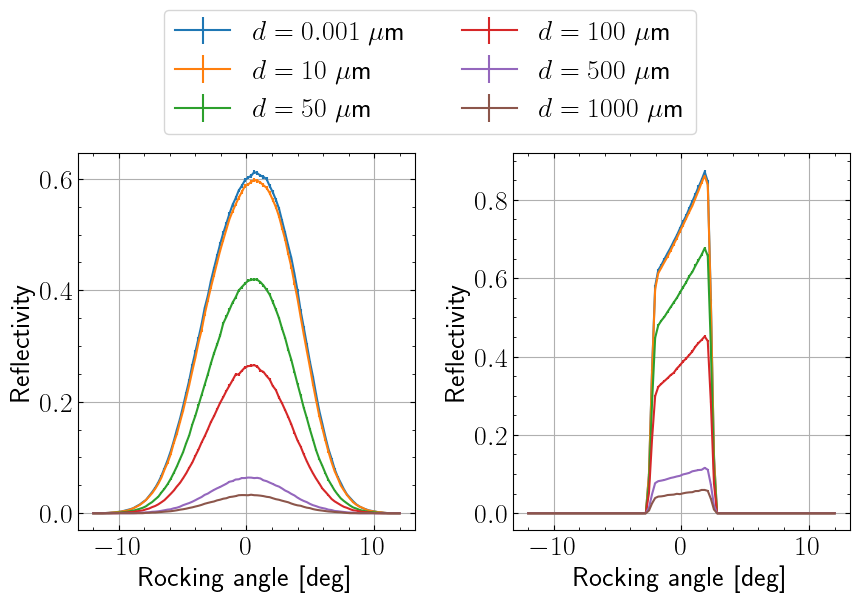

In [83]:
# Perform plotting of primary extinction dependence
def parse_mccode_multiarray_1d(path):
    """
    Parse a McCode 'multiarray_1d' ASCII file into (meta, df).

    Parameters
    ----------
    path : str | Path
        File path to the .dat/.txt export.

    Returns
    -------
    meta : dict
        Header metadata: title, xlabel, ylabel, xvars, yvars (list of (I, ERR) pairs), variables (list), etc.
    df : pd.DataFrame
        Tidy numeric data with columns named like in 'variables'.
    """
    path = Path(path)
    header = []
    data_lines = []

    # Read and separate header (starting with '#') from numeric data
    with path.open("r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            s = line.strip()
            if not s:
                continue
            if s.startswith("#") or s.startswith("\\#"):
                header.append(s.lstrip("\\").lstrip("#").strip())
            else:
                data_lines.append(s)

    # Parse header key:value pairs
    meta = {}
    for h in header:
        # e.g., "title: Scan of DeltaBragg"
        if ":" in h:
            key, val = h.split(":", 1)
            meta[key.strip().lower()] = val.strip().strip("'\"")

    # Variables list (column order)
    variables = meta.get("variables", "")
    if variables:
        # split by whitespace respecting names like 'entry_monitor_I'
        var_cols = variables.split()
    else:
        raise ValueError("No 'variables' line found in header; cannot map columns.")

    meta["variables"] = var_cols

    # yvars groups: e.g., "(entry_monitor_I,entry_monitor_ERR) (lam_mon_I,lam_mon_ERR) ..."
    yvars_raw = meta.get("yvars", "")
    y_pairs = []
    if yvars_raw:
        # Extract tuples between parentheses
        for tup in re.findall(r"\((.*?)\)", yvars_raw):
            parts = [p.strip() for p in tup.split(",")]
            if len(parts) == 2:
                y_pairs.append(tuple(parts))
    meta["yvars_pairs"] = y_pairs

    # Build DataFrame from numeric lines
    # Numeric values may be in scientific notation like 3.46703e-05
    # Split by whitespace and convert to float
    matrix = []
    for dl in data_lines:
        # Robust split: any whitespace
        nums = dl.split()
        if len(nums) != len(var_cols):
            # Some rows may be truncated; skip safely
            continue
        try:
            matrix.append([float(n) for n in nums])
        except ValueError:
            # If any token fails, skip row
            continue

    df = pd.DataFrame(matrix, columns=var_cols)

    # Convenience aliases
    meta["title"] = meta.get("title", "")
    meta["xlabel"] = meta.get("xlabel", meta.get("xvars", var_cols[0]))
    meta["ylabel"] = meta.get("ylabel", "Intensity")

    return meta, df


# ---- Quickstart (example) ----
# meta, df = parse_mccode_multiarray_1d("mccode.txt")
# fig, ax = plot_multi_1d(meta, df, show_err="band", legend_outside=True)
# plt.show()


# First load in the files
data = []
fig, ax = plt.subplots(figsize=(9,5), ncols=2)
file_list = []

for file in os.listdir('data'):
    if not file.startswith('dom_scan_mos'):
        continue
    file_list.append(f'data/{file}')
# get the file list sorted according to domain thickness 
file_vals = [float(x[17:]) for x in file_list]
order = np.argsort(file_vals)
print(order, file_vals)
file_list = [file_list[x] for x in order]
for file in file_list:
    meta, df = parse_mccode_multiarray_1d(f"{file}/mccode.dat")
    ax[0].errorbar(df['DeltaBragg']*60, df['x_monitor_I']/df['entry_lam_mon_I'], 
                df['x_monitor_ERR'], label=fr'$d={file[17:]}~\mu$m')

file_list=[]
for file in os.listdir('data'):
    if not file.startswith('dom_scan_per'):
        continue
    file_list.append(f'data/{file}')
# get the file list sorted according to domain thickness 
file_vals = [float(x[17:]) for x in file_list]
order = np.argsort(file_vals)
print(order, file_vals)
file_list = [file_list[x] for x in order]
for file in file_list:
    meta, df = parse_mccode_multiarray_1d(f"{file}/mccode.dat")
    ax[1].errorbar(df['DeltaBragg']*60, df['x_monitor_I']/df['entry_lam_mon_I'], 
                df['x_monitor_ERR'])
fig.legend(loc='lower center', bbox_to_anchor=(0.5,0.95), ncol=2)
ax[0].set(xlabel='Rocking angle [deg]', ylabel='Reflectivity')
ax[0].grid(True)
ax[1].grid(True)
ax[1].set(xlabel='Rocking angle [deg]', ylabel='Reflectivity')
fig.tight_layout()
fig.savefig("./domain_thickness.png",bbox_inches='tight', dpi=300)

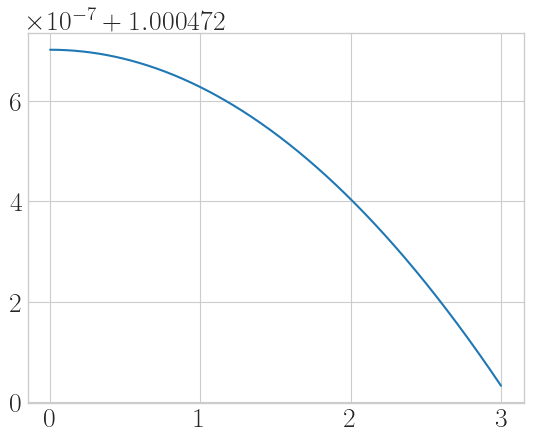

In [91]:
def ext_length(V0, lam, F):
    return V0/lam/F

def func(d,l):
    return np.exp(np.tanh(d/l)/d/l)

d = np.linspace(1e-9,3,1000)
l = 46
fig, ax = plt.subplots()

ax.plot(d,func(d,l))

[0 2 1 3 4] [6.0, 24.0, 12.0, 48.0, 96.0]
['data/si111_flat_rocking6', 'data/si111_flat_rocking12', 'data/si111_flat_rocking24', 'data/si111_flat_rocking48', 'data/si111_flat_rocking96']
data/si111_flat_rocking6
0.00407683
data/si111_flat_rocking12
0.00342257
data/si111_flat_rocking24
0.00258088
data/si111_flat_rocking48
0.00172844
data/si111_flat_rocking96
0.00105492
[4 1 0 2 3] [24.0, 12.0, 48.0, 96.0, 6.0]
['data/si111_flat_profile6', 'data/si111_flat_profile12', 'data/si111_flat_profile24', 'data/si111_flat_profile48', 'data/si111_flat_profile96']


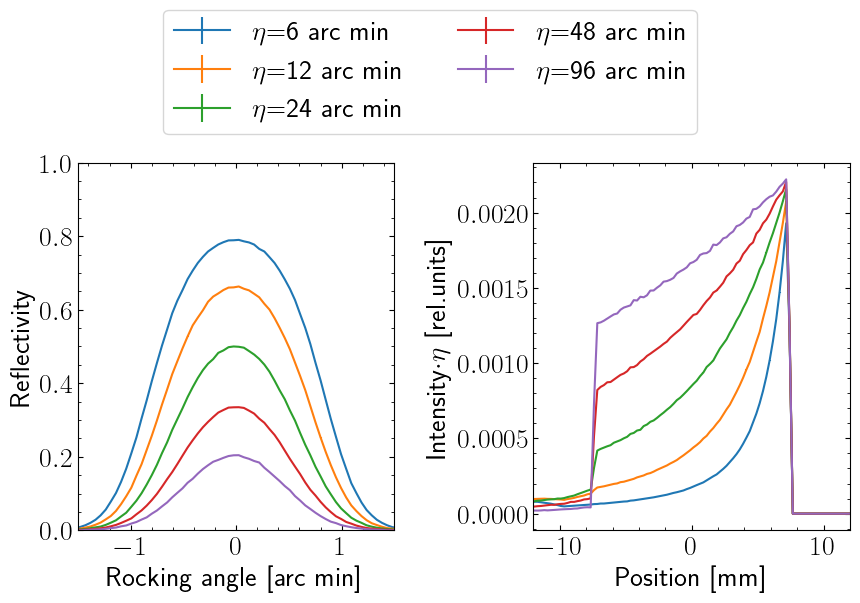

In [ ]:
# First load in the files
data = []
fig, ax = plt.subplots(figsize=(9,5), ncols=2)
file_list = []

for file in os.listdir('data'):
    if not file.startswith('si111_flat_rocking'):
        continue
    file_list.append(f'data/{file}')
# get the file list sorted according to domain thickness 
file_vals = [float(x[23:]) for x in file_list]
order = np.argsort(file_vals)
print(order, file_vals)
file_list = [file_list[x] for x in order]
print(file_list)
for file in file_list:
    print(file)
    meta, df = parse_mccode_multiarray_1d(f"{file}/mccode.dat")
    print(df['x_monitor_I'].max())
    ax[0].errorbar(df['DeltaBragg']*60/int(file[23:]), df['x_monitor_I']/df['entry_monitor_I'], 
                df['x_monitor_ERR'], label=fr'$\eta$={file[23:]}~arc min')
file_list = []
for file in os.listdir('data'):
    if not file.startswith('si111_flat_profile'):
        continue
    file_list.append(f'data/{file}')
# get the file list sorted according to domain thickness 
file_vals = [float(x[23:]) for x in file_list]
order = np.argsort(file_vals)
print(order, file_vals)
file_list = [file_list[x] for x in order]
print(file_list)
for file in file_list:
    dat = ms.load_data(file)[2]
    x = np.linspace(*dat.metadata.limits, len(dat.Intensity))*10
    ax[1].errorbar(x, dat.Intensity*int(file[23:]), dat.Error)

fig.legend(loc='lower center', bbox_to_anchor=(0.5,0.95), ncol=2)
ax[0].set(xlabel='Rocking angle [arc min]', ylabel='Reflectivity', xlim=(-1.5,1.5), ylim=(0,1))
# ax[0].grid(True)
# ax[1].grid(True)
ax[1].set(xlabel='Position [mm]', ylabel=fr'Intensity$\cdot\eta$ [rel.units]',
          xlim=(-12,12))
fig.tight_layout()
# fig.savefig("./domain_thickness.png",bbox_inches='tight', dpi=300)

[3 4 1 0 2] [24.0, 12.0, 48.0, 3.0, 6.0]
['data/si111_bent_rocking3', 'data/si111_bent_rocking6', 'data/si111_bent_rocking12', 'data/si111_bent_rocking24', 'data/si111_bent_rocking48']
data/si111_bent_rocking3
0.00291076
data/si111_bent_rocking6
0.00288956
data/si111_bent_rocking12
0.00285182
data/si111_bent_rocking24
0.00248708
data/si111_bent_rocking48
0.0017234
[4 3 1 0 2] [24.0, 12.0, 48.0, 6.0, 3.0]
['data/si111_bent_profile3', 'data/si111_bent_profile6', 'data/si111_bent_profile12', 'data/si111_bent_profile24', 'data/si111_bent_profile48']


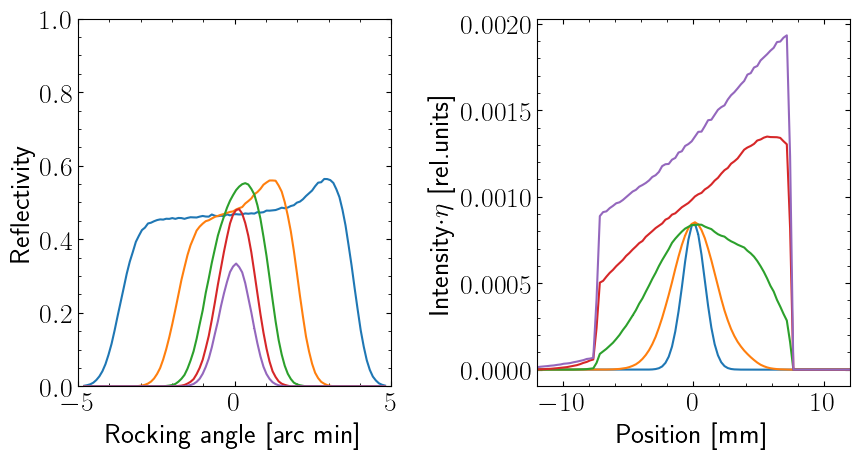

In [192]:
# First load in the files
data = []
fig, ax = plt.subplots(figsize=(9,5), ncols=2)
file_list = []

for file in os.listdir('data'):
    if not file.startswith('si111_bent_rocking'):
        continue
    file_list.append(f'data/{file}')
# get the file list sorted according to domain thickness 
file_vals = [float(x[23:]) for x in file_list]
order = np.argsort(file_vals)
print(order, file_vals)
file_list = [file_list[x] for x in order]
print(file_list)
for file in file_list:
    print(file)
    meta, df = parse_mccode_multiarray_1d(f"{file}/mccode.dat")
    print(df['x_monitor_I'].max())
    ax[0].errorbar(df['DeltaBragg']*60/int(file[23:]), df['x_monitor_I']/df['entry_monitor_I'], 
                df['x_monitor_ERR'], label=fr'$\eta$={file[23:]}~arc min')
file_list = []
for file in os.listdir('data'):
    if not file.startswith('si111_bent_profile'):
        continue
    file_list.append(f'data/{file}')
# get the file list sorted according to domain thickness 
file_vals = [float(x[23:]) for x in file_list]
order = np.argsort(file_vals)
print(order, file_vals)
file_list = [file_list[x] for x in order]
print(file_list)
for file in file_list:
    dat = ms.load_data(file)[2]
    x = np.linspace(*dat.metadata.limits, len(dat.Intensity))*10
    ax[1].errorbar(x, dat.Intensity*int(file[23:]), dat.Error, label=fr'$\eta$={file[23:]}~arc min')
# file_list=[]
# for file in os.listdir('data'):
#     if not file.startswith('si111_bent_rocking'):
#         continue
#     file_list.append(f'data/{file}')
# # get the file list sorted according to domain thickness 
# file_vals = [float(x[23:]) for x in file_list]
# order = np.argsort(file_vals)
# print(order, file_vals)
# file_list = [file_list[x] for x in order]
# for file in file_list:
#     meta, df = parse_mccode_multiarray_1d(f"{file}/mccode.dat")
#     ax[1].errorbar(df['DeltaBragg']*60, df['x_monitor_I']/df['entry_lam_mon_I'], 
#                 df['x_monitor_ERR'])
# fig.legend(loc='lower center', bbox_to_anchor=(0.5,0.95), ncol=2)
ax[0].set(xlabel='Rocking angle [arc min]', ylabel='Reflectivity', xlim=(-5,5), ylim=(0,1))
# ax[0].grid(True)
# ax[1].grid(True)
ax[1].set(xlabel='Position [mm]', ylabel=fr'Intensity$\cdot\eta$ [rel.units]',
          xlim=(-12,12))
fig.tight_layout()
# fig.savefig("./domain_thickness.png",bbox_inches='tight', dpi=300)